In [10]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import norm
import math

American and Europian option pricing using different time steps

In [3]:
S0 = 50 
K = 50 
T = 1 
r = 0.08 
sig = 0.3

In [ ]:
#The up and down factors(according to different models two examples are given)
def UnD(sig , t):
    u = np.exp(sig * (t**0.5))
    d = np.exp(-sig*(t**0.5))
    return [u , d]
def UnDmod(r , sig , t):
    beta = (np.exp(-r*t) + np.exp((r+sig*sig)*t))/2
    u = beta + np.sqrt(beta**2 - 1)
    d = beta - np.sqrt(beta**2 - 1)
    return [u , d]
def P(u , d , riskfree):
    return (riskfree-d)/(u-d)

In [ ]:

M = [5 , 10 , 20]
def europe(S0 , K , T , M , r , sig , type , optype):
    t = T/M 
    if(type == 1):
        u = UnD(sig , t)[0]
        d = UnD(sig , t)[1]
    else :
        u = UnDmod(r , sig , t)[0]
        d = UnDmod(r , sig , t)[1]
    riskfree = np.exp(r*t)
    p = P(u , d, riskfree)
    A = np.zeros((M+1 , M+1))
    for i in range(M+1):
        if(optype == "CALL"):
            A[M][i] = max(S0 * (u**(M-i)) * (d**i) -K , 0)
        else :
            A[M][i] = max(-1*S0 * (u**(M-i)) * (d**i) + K , 0)
    j = M-1 
    while(j>=0):
        for i in range(j+1):
            A[j][i] = A[j+1][i]*p + (1-p)*A[j+1][i+1]
            A[j][i] = A[j][i]/riskfree
        j-=1
    return A
def americano(S0 , K , T , M , r , sig , type , optype):
    t = T/M 
    if(type == 1):
        u = UnD(sig , t)[0]
        d = UnD(sig , t)[1]
    else :
        u = UnDmod(r , sig , t)[0]
        d = UnDmod(r , sig , t)[1]
    riskfree = np.exp(r*t)
    p = P(u , d, riskfree)
    A = np.zeros((M+1 , M+1))
    for i in range(M+1):
        if(optype == "CALL"):
            A[M][i] = max(S0 * (u**(M-i)) * (d**i) -K , 0)
        else :
            A[M][i] = max(-1*S0 * (u**(M-i)) * (d**i) + K , 0)
    j = M-1 
    while(j>=0):
        for i in range(j+1):
            A[j][i] = A[j+1][i]*p + (1-p)*A[j+1][i+1]
            A[j][i] = A[j][i]/riskfree
            if(optype == "CALL"):
                excr= max(S0 * (u**(j-i)) * (d**i) -K , 0)
            else :
                excr = max(-1*S0 * (u**(j-i)) * (d**i) + K , 0)
            A[j][i] = max(A[j][i] , excr)
        j-=1
    return A

In [6]:
def repeat(M , europe , type , optype):
    for i in range(len(M)):
        test = europe(S0 , K , T , M[i] , r , sig , type , optype)
        print(f"for M = {M[i]} and model {type} price of  {europe.__name__} {optype} option is {test[0][0]}")

In [7]:
repeat(M , europe , 1 , "CALL")

for M = 5 and model 1 price of  europe CALL option is 8.11162793236156
for M = 10 and model 1 price of  europe CALL option is 7.709777141823939
for M = 20 and model 1 price of  europe CALL option is 7.782172411240754


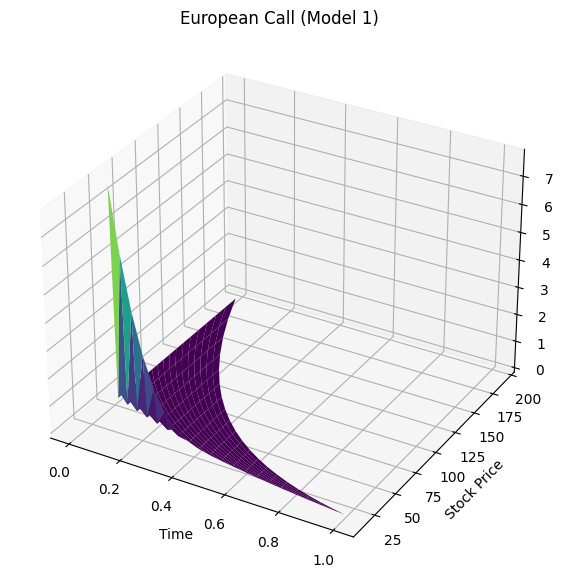

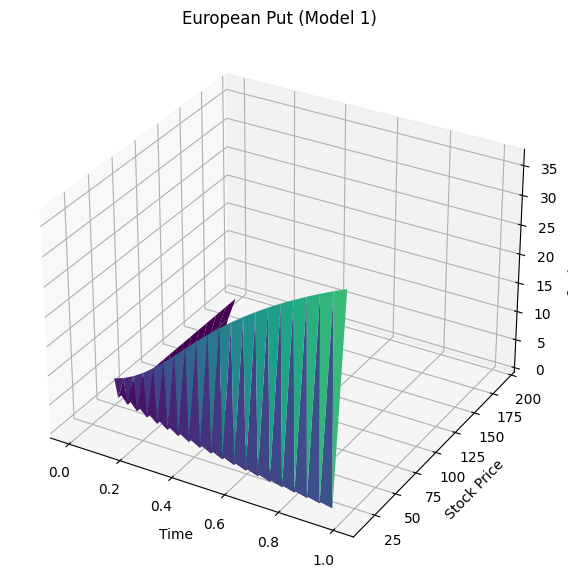

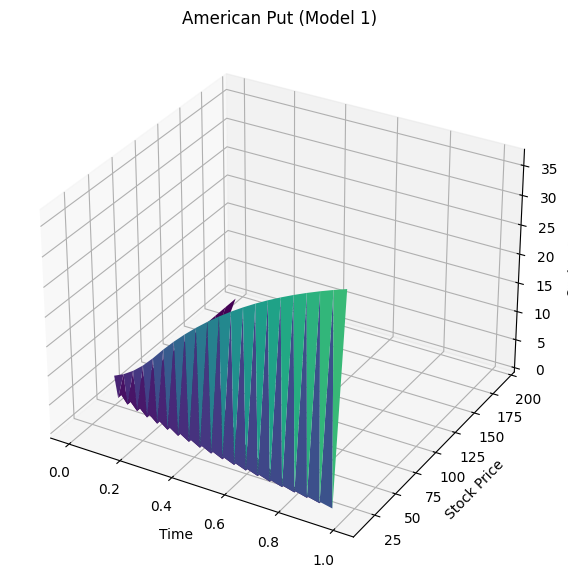

In [8]:
def plot_option_surface(A, M, T, S0, u, d, title):
    times = np.linspace(0, T, M+1)
    stock_prices = np.zeros((M+1, M+1))
    for t in range(M+1):
        for i in range(t+1):
            stock_prices[t, i] = S0 * (u**(t-i)) * (d**i)
        for i in range(t+1, M+1):
            stock_prices[t, i] = np.nan  # mask unused entries

    X, Y = np.meshgrid(times, np.arange(M+1))
    Z = np.where(np.isnan(stock_prices), np.nan, A.T)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, stock_prices, Z, cmap='viridis')
    ax.set_xlabel('Time')
    ax.set_ylabel('Stock Price')
    ax.set_zlabel('Option Price')
    ax.set_title(title)
    plt.show()

M = 20
t = T / M

# For model 1 (u, d)
u1, d1 = UnD(sig, t)
# For model 2 (u, d)
u2, d2 = UnDmod(r, sig, t)

# European Call
eucall1 = europe(S0, K, T, M, r, sig, 1, "CALL")
plot_option_surface(eucall1, M, T, S0, u1, d1, "European Call (Model 1)")

# European Put
euput1 = europe(S0, K, T, M, r, sig, 1, "PUT")
plot_option_surface(euput1, M, T, S0, u1, d1, "European Put (Model 1)")

# American Put
amput1 = americano(S0, K, T, M, r, sig, 1, "PUT")
plot_option_surface(amput1, M, T, S0, u1, d1, "American Put (Model 1)")

<h1>Europian option pricing using numerical pde solving methods</h1> 
explicit method <br>
implicit <br>
crank-nicholson method

In [11]:
def y(x , qdel , CALL  ):
  if(CALL):
    return max(0 ,  np.exp(x*(qdel + 1 )/2) - np.exp(x*(qdel - 1)/2))
  else:
    return max(0 ,  np.exp(x*(qdel - 1 )/2) - np.exp(x*(qdel  + 1)/2))

def explicit(xmin , xmax , M, N , CALL ):
  A = np.zeros((M+1 , N+1))
  dx = (xmax - xmin)/N
  dt = T/M
  lam = dt/(dx**2)
  qdel = 2*r/(sig*sig)
  for i in range(N+1):
    A[0][i] = y(xmin + dx*i , qdel , CALL )
  for i in range(1 , M+1):
    for j in range(1 , N):
      A[i][j] = lam*A[i-1][j-1] + (1-2*lam)*A[i-1][j] + lam*A[i-1][j+1]
  return A
def implicit(xmin , xmax , M, N , CALL ):
  A = np.zeros((M+1 , N+1))
  dx = (xmax - xmin)/N
  dt = T/M
  lam = dt/(dx**2)
  qdel = 2*r/(sig*sig)
  for i in range(N+1):
    A[0][i] = y(xmin + dx*i , qdel , CALL )
  mat = np.zeros((M-1 , M-1))
  for i in range(M-1):
    mat[i][i] = 1+2*lam
    if(i+1 < M-1):
      mat[i][i+1] = -1*lam
    if(i-1>=0):
      mat[i][i-1] = -1*lam
  invmat = np.linalg.inv(mat)
  for i in range(1 , M+1):
   A[i][1:M] = (invmat@A[i-1][1: M])
  return A
def crank_nicholson(xmin , xmax , M, N , CALL ):
  A = np.zeros((M+1 , N+1))
  dx = (xmax - xmin)/N
  dt = T/M
  lam = dt/(dx**2)
  qdel = 2*r/(sig*sig)
  for i in range(N+1):
    A[0][i] =y(xmin + dx*i , qdel , CALL )
  mat = np.zeros((M-1 , M-1))
  matB = np.zeros((M-1 ,   M-1))
  for i in range(M-1):
    mat[i][i] = 1+lam
    if(i+1 < M-1):
      mat[i][i+1] = -1*lam/2
    if(i-1>=0):
      mat[i][i-1] = -1*lam/2
    matB[i][i] = 1-lam
    if(i+1 < M-1):
      matB[i][i+1] = lam/2
    if(i-1>=0):
      matB[i][i-1] = lam/2
  invmat = np.linalg.inv(mat)
  for i in range(1 , M+1):
   A[i][1:M] = invmat@matB@A[i-1][1: M]
  return A



In [12]:
xmin = -1
xmax = +1
M = 100
N = 100
#this is only the y(x , tao) value at diff x , t
C1 = explicit(xmin , xmax , M, N , True)
C2 = implicit(xmin , xmax , M, N , True)
C3 = crank_nicholson(xmin , xmax , M, N , True)
P1 = explicit(xmin , xmax , M, N , False)
P2 = implicit(xmin , xmax , M, N , False)
P3 = crank_nicholson(xmin , xmax , M, N , False)
def givecost(A):
  B = np.zeros((M+1 , N+1))
  qdel = 2*r/(sig*sig)
  dt = T/M
  dx = (xmax - xmin)/N
  for i in range(M+1):
    for j in range(N+1):
      tao = i*dt
      x = xmin + j*dx
      A[i][j] = K*np.exp(-0.5* (qdel - 1)*x - (0.25*(qdel -1 )**2 + qdel)*tao)*A[i][j]
  return A
lst = [C1 , C2 , C3 , P1, P2 , P3 ]
for i in range(6):
  lst[i] = givecost(lst[i])

In [13]:
def bsm_option_price(S, K, T, r, sig, option_type='call'):
  d1 = (np.log(S / K) + (r + 0.5 * sig**2) * T) / (sig * np.sqrt(T))
  d2 = d1 - sig * np.sqrt(T)

  if option_type == 'call':
    price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  elif option_type == 'put':
    price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
  return price

In [14]:
timestamp = [ 0 , 0.25 , 0.5 , 0.75 , 0.95]
dx = (xmax - xmin)/100
dt = T/M
for t in timestamp:
  for j in range(N+1):
    x = xmin + j*dx
    S =  K*np.exp(x)
    closed_form  = bsm_option_price(S , K ,  T-t , r , sig , 'put')
    tao = (T-t)*sig*sig/2
    index =int(math.floor(tao/dt))
    numerical = P1[index][j]
    print(f"For PUT OPTION with EXPLICIT method  at time = {t} and price of stock = {S} value given by closed form solution is {closed_form} and numerical solution is {numerical}")

For PUT OPTION with EXPLICIT method  at time = 0 and price of stock = 18.393972058572118 value given by closed form solution is 27.76445406224911 and numerical solution is 0.0
For PUT OPTION with EXPLICIT method  at time = 0 and price of stock = 18.765554942569977 value given by closed form solution is 27.39360374832719 and numerical solution is -2142641.03106211
For PUT OPTION with EXPLICIT method  at time = 0 and price of stock = 19.144644298755605 value given by closed form solution is 27.015435967438396 and numerical solution is 1731208.9115218117
For PUT OPTION with EXPLICIT method  at time = 0 and price of stock = 19.531391767926056 value given by closed form solution is 26.629843096706214 and numerical solution is -442655.24862507015
For PUT OPTION with EXPLICIT method  at time = 0 and price of stock = 19.925952054225707 value given by closed form solution is 26.236723446259067 and numerical solution is 26.656295623808386
For PUT OPTION with EXPLICIT method  at time = 0 and pric

Values at the margins are absurd but matches with the bsm at the centre this happens because the boundary conditions are not optimal

In [21]:
#AMERICAN OPTION PRICING 
S_0 = 50
K = 50
T = 1
r = 0.08
sigma = 0.3
m = 500
v_max = 500
x_min = -1
x_max = 1
dx = (x_max - x_min) / m
dt = 0.5 * (sigma**2) * T / v_max  
lam = dt / (dx * dx)
q = 2*r/(sigma**2)

In [17]:
x_grid = x_min + np.arange(m + 1) * dx
def G(x, tau):
    return np.exp(0.25 * tau * ((q- 1.0)**2 + 4.0 * q)) * np.maximum(
        np.exp(0.5 * x * (q- 1.0)) - np.exp(0.5 * x * (q + 1.0)),
        0.0
    )

In [18]:
A = np.zeros((m - 1, m - 1))
theta = 0.5
alpha = lam * theta
for i in range(m - 1):
    A[i, i] = 1.0 + 2.0 * lam * theta
    if (i + 1) < (m - 1):
        A[i, i + 1] = -lam * theta
        A[i + 1, i] = -lam * theta
y = np.zeros((v_max + 1, m + 1))
y[0, :] = G(x_grid, 0.0)
for v in range(1, v_max + 1):
    y[v, 0] = G(x_grid[0], v * dt)
    y[v, m] = G(x_grid[m], v * dt) 

In [19]:
w = y[0, 1:m].copy()  

for v in range(v_max):
    b = np.zeros(m - 1)

    g0_v  = G(x_grid[0],     v * dt)
    g0_v1 = G(x_grid[0], (v + 1) * dt)
    b[0] = w[0] + lam * (1.0 - theta) * (w[1] - 2.0 * w[0] + g0_v) + alpha * g0_v1

    for i in range(1, m - 2):
        b[i] = w[i] + lam * (1.0 - theta) * (w[i + 1] - 2.0 * w[i] + w[i - 1])

    gM_v  = G(x_grid[m], v * dt)
    gM_v1 = G(x_grid[m], (v + 1) * dt)
    b[m - 2] = w[m - 2] + lam * (1.0 - theta) * (w[m - 3] - 2.0 * w[m - 2] + gM_v) + alpha * gM_v1
    g = np.zeros(m - 1)
    for i in range(m - 1):
        g[i] = G(x_grid[i + 1], (v + 1) * dt)  

    V = np.maximum(w, g)

    eps = 1e-8
    wr = 1.5   
    max_iter = 20000

    for _ in range(max_iter):
        V_new = V.copy()

        for i in range(m - 1):
            v_im1_new = 0.0 if i == 0     else V_new[i - 1]  
            v_ip1     = 0.0 if i == m - 2 else V[i + 1]     
            rho = (b[i] + alpha * (v_im1_new + v_ip1)) / (1.0 + 2.0 * alpha)

            temp = V[i] + wr * (rho - V[i])
            V_new[i] = max(g[i], temp)  

        diff = np.linalg.norm(V_new - V, 2)
        V = V_new
        if diff <= eps:
            break
    w = V
    y[v + 1, 1:m] = w


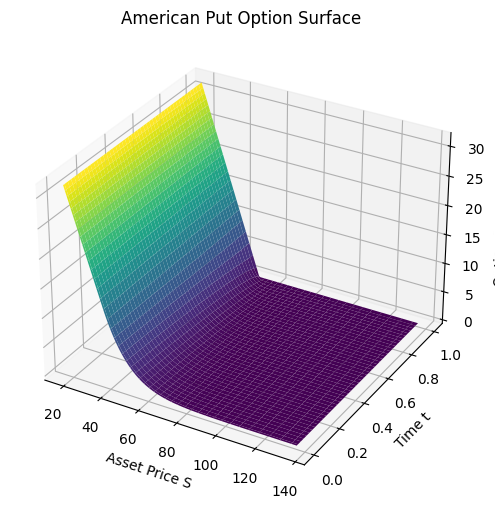

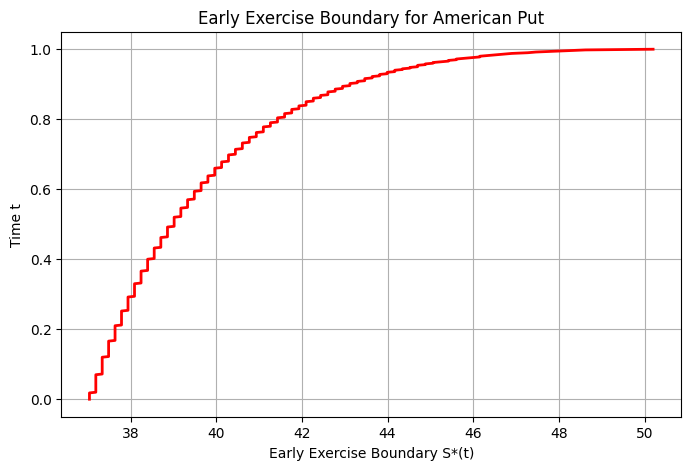

In [20]:
x_grid = np.linspace(x_min, x_max, m+1)
S_grid = K * np.exp(x_grid)

V_vals = np.zeros_like(y)  
t_grid = np.zeros(v_max+1)

for v in range(v_max+1):
    tau_v = v * dt
    t_grid[v] = T - 2.0 * tau_v / (sigma**2)
    factor_tau = np.exp(-0.25*((q-1)**2 + 4*q) * tau_v)
    for i in range(m+1):
        x_i = x_grid[i]
        factor_x = np.exp(-0.5*(q - 1)*x_i)
        factor = factor_x * factor_tau
        V_vals[v,i] = K * factor * y[v,i]
Sf = np.zeros(v_max+1)
for v in range(v_max+1):
    for i in range(m+1):
        s = K*np.exp(x_grid[i])
        if abs(V_vals[v][i] - (K - s)) > 1e-6:
            Sf[v] = s
            break
    
from mpl_toolkits.mplot3d import Axes3D

T_mesh, S_mesh = np.meshgrid(t_grid, S_grid)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_mesh, T_mesh, V_vals.T, cmap='viridis')
ax.set_xlabel("Asset Price S")
ax.set_ylabel("Time t")
ax.set_zlabel("Option Price V(S,t)")
ax.set_title("American Put Option Surface")
plt.show()
plt.figure(figsize=(8,5))
plt.plot(Sf, t_grid, 'r-', linewidth=2)
plt.ylabel("Time t")
plt.xlabel("Early Exercise Boundary S*(t)")
plt.title("Early Exercise Boundary for American Put")
plt.grid(True)
plt.show()


Matches the expected pattern

In [22]:
from scipy import optimize

1 . Approaximation based on interplation (H.E.Johnson , 1983 , Journal of Financial Quantitative Analysis)<br>
2 . Quadratic Approximation (L.W. MacMillan, 1986, Advances in Futures and
Options Research)

In [25]:
S_0 = 50 
K = 50 
T = 1  
r = 0.08 
sig = 0.3 
m = 100
v_max = 100
x_min = -1
x_max = 1
dx = (x_max - x_min) / m
dt = 0.5 * (sig**2) * T / v_max  
lam = dt / (dx * dx)
def Black_scholes(S_0, K, T, r, sig):
    d1 = (np.log(S_0 / K) + (r + 0.5 * sig**2) * T) / (sig * np.sqrt(T))
    d2 = d1 - sig * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S_0 * norm.cdf(-d1)
    return put_price


In [26]:
def linear_interpolation(tao , S):
    if(tao == 0 ):
        return max(K-S,0)
    p1 = Black_scholes(S , K , tao , r , sig)
    p2 = Black_scholes(S , K*np.exp(r*tao) , tao , r , sig)
    a0 = 3.9649 
    a1 = 0.032325
    b0 = 1.04083 
    b1 = 0.00963
    gamma = sig*sig*tao/(b0*sig*sig*tao + b1)
    Sf = K*((2*r/(sig*sig + 2*r))**gamma)
    beta = np.log(S/Sf) /np.log(K/Sf)
    base = r*tao/(a0*r*tao + a1)
    alp = base**beta 
    #print(p1 , p2 , gamma , Sf , base , alp)
    return (1-alp)*p1 + alp*p2 

In [27]:
#cryers algorithm 
q = 2*r/(sig**2)
x_grid = x_min + np.arange(m + 1) * dx
def G(x, tau):
    return np.exp(0.25 * tau * ((q- 1.0)**2 + 4.0 * q)) * np.maximum(
        np.exp(0.5 * x * (q- 1.0)) - np.exp(0.5 * x * (q + 1.0)),
        0.0
    )
A = np.zeros((m - 1, m - 1))
theta = 0.5
alpha = lam * theta
for i in range(m - 1):
    A[i, i] = 1.0 + 2.0 * lam * theta
    if (i + 1) < (m - 1):
        A[i, i + 1] = -lam * theta
        A[i + 1, i] = -lam * theta
y = np.zeros((v_max , m + 1))
y[0, :] = G(x_grid, 0.0)
for v in range(1, v_max ):
    y[v, 0] = G(x_grid[0], v * dt)
    y[v, m] = G(x_grid[m], v * dt) 
w = y[0, 1:m].copy()  

for v in range(v_max-1):
    b = np.zeros(m - 1)

    g0_v  = G(x_grid[0],     v * dt)
    g0_v1 = G(x_grid[0], (v + 1) * dt)
    b[0] = w[0] + lam * (1.0 - theta) * (w[1] - 2.0 * w[0] + g0_v) + alpha * g0_v1

    for i in range(1, m - 2):
        b[i] = w[i] + lam * (1.0 - theta) * (w[i + 1] - 2.0 * w[i] + w[i - 1])

    gM_v  = G(x_grid[m], v * dt)
    gM_v1 = G(x_grid[m], (v + 1) * dt)
    b[m - 2] = w[m - 2] + lam * (1.0 - theta) * (w[m - 3] - 2.0 * w[m - 2] + gM_v) + alpha * gM_v1
    g = np.zeros(m - 1)
    for i in range(m - 1):
        g[i] = G(x_grid[i + 1], (v + 1) * dt)  

    V = np.maximum(w, g)

    eps = 1e-8
    wr = 1.5   
    max_iter = 20000

    for _ in range(max_iter):
        V_new = V.copy()

        for i in range(m - 1):
            v_im1_new = 0.0 if i == 0     else V_new[i - 1]  
            v_ip1     = 0.0 if i == m - 2 else V[i + 1]     
            rho = (b[i] + alpha * (v_im1_new + v_ip1)) / (1.0 + 2.0 * alpha)

            temp = V[i] + wr * (rho - V[i])
            V_new[i] = max(g[i], temp)  

        diff = np.linalg.norm(V_new - V, 2)
        V = V_new
        if diff <= eps:
            break
    w = V
    y[v + 1, 1:m] = w
x_grid = np.linspace(x_min, x_max, m+1)
S_grid = K * np.exp(x_grid)

V_vals = np.zeros_like(y)  
t_grid = np.zeros(v_max)

for v in range(v_max):
    tau_v = v * dt
    t_grid[v] = T - 2.0 * tau_v / (sig**2)
    factor_tau = np.exp(-0.25*((q-1)**2 + 4*q) * tau_v)
    for i in range(m+1):
        x_i = x_grid[i]
        factor_x = np.exp(-0.5*(q - 1)*x_i)
        factor = factor_x * factor_tau
        V_vals[v,i] = K * factor * y[v,i]
Sf = np.zeros(v_max)
for v in range(v_max):
    for i in range(m+1):
        s = K*np.exp(x_grid[i])
        if abs(V_vals[v][i] - (K - s)) > 1e-6:
            Sf[v] = s
            break

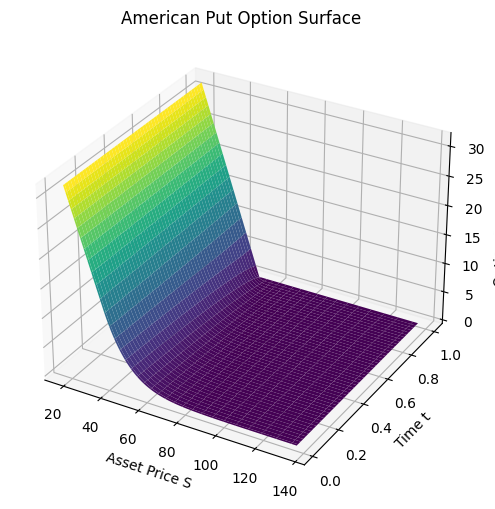

In [28]:
from mpl_toolkits.mplot3d import Axes3D

T_mesh, S_mesh = np.meshgrid(t_grid, S_grid)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_mesh, T_mesh, V_vals.T, cmap='viridis')
ax.set_xlabel("Asset Price S")
ax.set_ylabel("Time t")
ax.set_zlabel("Option Price V(S,t)")
ax.set_title("American Put Option Surface")
plt.show()

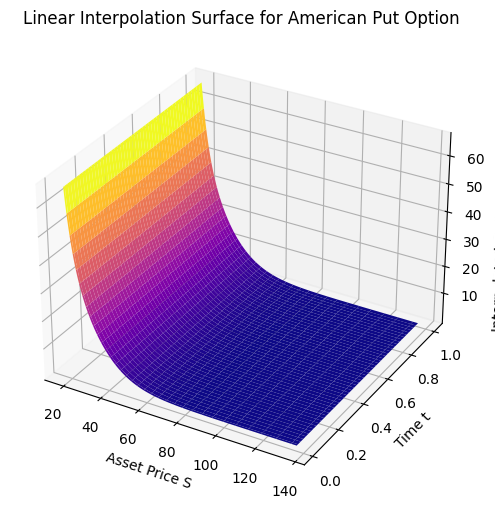

In [29]:
LI_vals = np.zeros_like(V_vals)
for v in range(v_max):
    tau_v = v * dt
    for i in range(m + 1):
        LI_vals[v, i] = linear_interpolation(1 - tau_v, S_grid[i])
# Plot the interpolated surface
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_mesh, T_mesh, LI_vals.T, cmap='plasma')
ax.set_xlabel("Asset Price S")
ax.set_ylabel("Time t")
ax.set_zlabel("Interpolated Option Price V(S,t)")
ax.set_title("Linear Interpolation Surface for American Put Option")
plt.show()

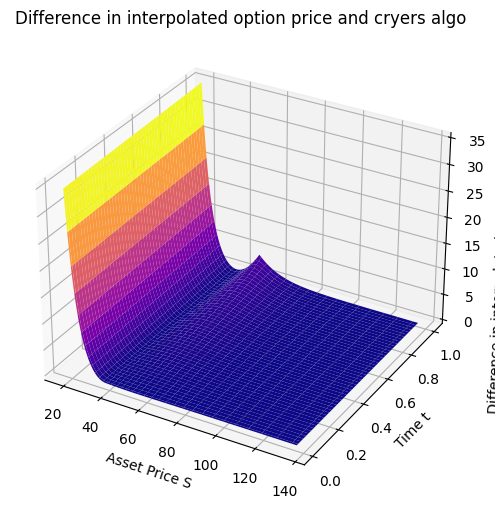

In [30]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_mesh, T_mesh, LI_vals.T - V_vals.T, cmap='plasma')
ax.set_xlabel("Asset Price S")
ax.set_ylabel("Time t")
ax.set_zlabel("Difference in interpolated option price and cryers algo ")
ax.set_title("Difference in interpolated option price and cryers algo")
plt.show()

In [31]:
def quad(S0 , K ,  T=T):
    q = (2*r) / (sig**2)
    H = 1 - np.exp(-r*T)
    l = -0.5*((q-1) + np.sqrt((q-1)**2 + 4*q/H))

    d1 = lambda x: (np.log(x/K) + (r + 0.5*sig**2)*T) / (sig*np.sqrt(T))
    d2 = lambda x: d1(x) - sig*np.sqrt(T)
    opt_exp = lambda x: x*norm.cdf(d1(x))*(1 - 1/l) + K*np.exp(-r*T)*(1 - norm.cdf(d2(x))) - K

    Sf = optimize.newton(opt_exp, 100)
    return Black_scholes(S0 , K ,T, r , sig) - Sf*norm.cdf(d1(Sf))*(S0/Sf)**l/l if S0 > Sf else K - S0

In [32]:
QA_vals = np.zeros_like(V_vals)
for v in range(v_max):
    tau_v = v * dt
    for i in range(m + 1):
        QA_vals[v, i] = quad(S_grid[i], K, 1-tau_v)

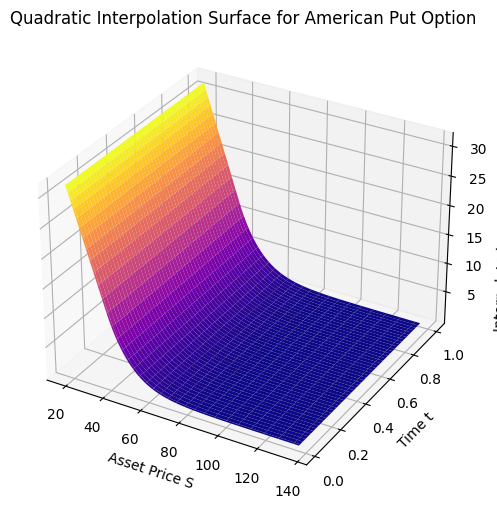

In [34]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_mesh, T_mesh, QA_vals.T, cmap='plasma')
ax.set_xlabel("Asset Price S")
ax.set_ylabel("Time t")
ax.set_zlabel("Interpolated Option Price V(S,t)")
ax.set_title("Quadratic Interpolation Surface for American Put Option")
plt.show()

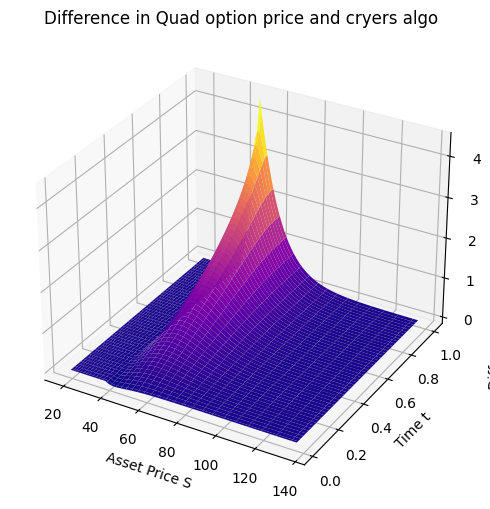

In [36]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_mesh, T_mesh, QA_vals.T - V_vals.T, cmap='plasma')
ax.set_xlabel("Asset Price S")
ax.set_ylabel("Time t")
ax.set_zlabel("Difference in Quad option price and cryers algo ")
ax.set_title("Difference in Quad option price and cryers algo")
plt.show()